# Brownian Motion Example
Tracking and mapping particle motion of water under a microscope. 

Depending on where you are running this, you may need to add trkpy and pims to your python modules.

Note: this notebook will *not* give you good results as-is.  You need to tune the particle ID parameters to give good results on your particular video!

In [3]:
# import packages
import pims
import trackpy as tp
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import matplotlib.pyplot as plt

# Don't know if this is necessary
%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'  # Set grayscale images as default.


Read in a movie using the pims package.  Videos are split into single frames.

In [2]:
# Note: make sure you've downloaded the movie into the same folder as this notebook
video = pims.Video('MovieCapture_19.11.01_01.mov')

Learn more about Video on pims @ http://soft-matter.github.io/pims/v0.6.1/video.html

In [ ]:
# Get details on this file
video

[TAKEAWAYS FROM CALLING 'video']

In [3]:
# convert movie from color to greyscale
from pims import pipeline

@pipeline
def as_grey(frame):
    red = frame[:, :, 0]
    green = frame[:, :, 1]
    blue = frame[:, :, 2]
    return 0.2125 * red + 0.7154 * green + 0.0721 * blue


Frame([[117.4382, 119.4382, 121.4382, ..., 130.5596, 129.5596, 129.5596],
       [117.4382, 119.4382, 120.4382, ..., 128.5596, 128.5596, 127.5596],
       [117.4382, 119.4382, 119.4382, ..., 127.5596, 126.5596, 126.5596],
       ...,
       [ 84.0203,  83.0203,  82.8136, ..., 104.2616, 104.2616, 103.2616],
       [ 84.2328,  83.2328,  82.8136, ..., 104.1895, 104.7607, 103.7607],
       [ 84.2328,  83.2328,  81.8136, ..., 104.1895, 104.7607, 103.7607]])
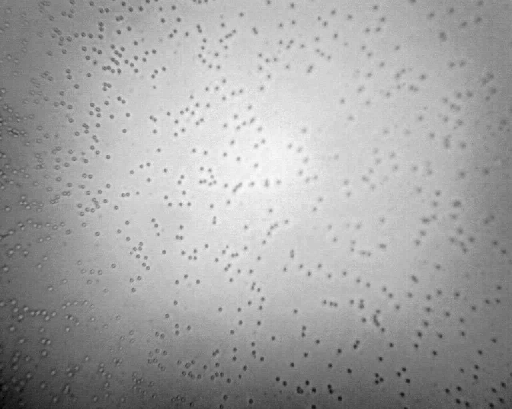

In [4]:
# check as_grey works on single frame (eg. video[10]) before sending all frames through the function
as_grey(video[10])

Convert the entire video into greyscale, then each frame can be accessed just like any other array.

In [5]:
processed_video = as_grey(video)

Look at a single frame of the processed greyscale video to verify changes have been made. Calling plt.imshow to get pixel axes on the frame

Frame([[120.294 , 120.294 , 120.294 , ..., 126.5596, 126.5596, 126.5596],
       [120.294 , 120.294 , 120.294 , ..., 126.5596, 126.5596, 126.5596],
       [119.294 , 119.294 , 119.294 , ..., 126.5596, 126.5596, 126.5596],
       ...,
       [ 83.6734,  84.6734,  83.956 , ..., 104.6183, 104.6183, 104.6183],
       [ 83.6734,  83.6734,  83.5272, ..., 104.6183, 103.6183, 103.6183],
       [ 83.6734,  83.6734,  83.5272, ..., 103.6183, 102.6183, 101.6183]])
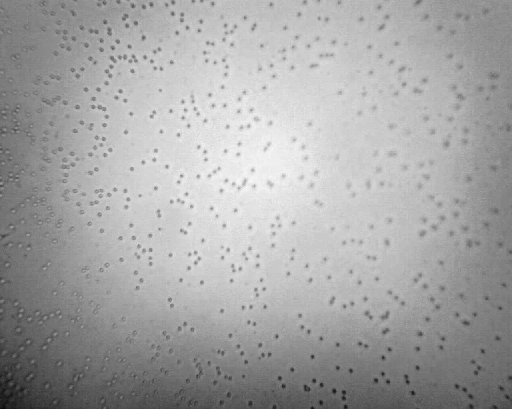

In [7]:
plt.imshow(processed_video[0])

Find the particles and their features using trkpy.locate. Using trackpy requires a little bit of guess and check. The parameters we are customizing are:
- diameter, diam of a single particle in pixels)
- minmass, we are chosing something ~100 because this is an integer image
- invert, the particles are dark against a light background, invert search to locate the dark spots

The values you see set to these parameters were found after some guess and check on what best captures the particles. You will have to adjust these with each video since the quality of each video will vary. The goal is to locate *enough* particles to analyze. We don't necessarily need to capture all of them. 

Mess around will a couple frames to see how well set values of parameters captures various frames. When we are statisfied with the quantity of particles being captured, we will track and store their batch and movement. 

Learn more about trkpy.locate @ http://soft-matter.github.io/trackpy/dev/generated/trackpy.locate.html#trackpy.locate

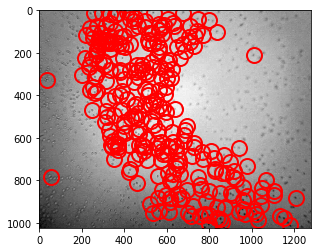

In [37]:
iframe=1
df = tp.locate(processed_video[iframe], diameter=9, minmass=150, invert=True)
plt.figure()
tp.annotate(df, processed_video[iframe])

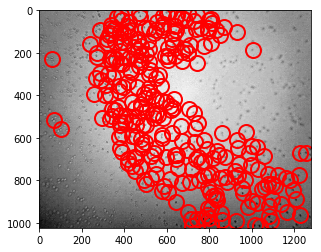

In [38]:
iframe=120
df = tp.locate(processed_video[iframe], diameter=9, minmass=150, invert=True)
plt.figure()
tp.annotate(df, processed_video[iframe])

We can plot the attributes, particularly the mass, to find a good lower limit on this value.  Adjust the value of minmass above until you are just selecting the beads. Make sure your selection works for both the start and the end of the video.  

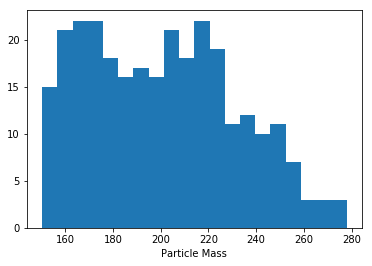

In [39]:
plt.hist(df['mass'], bins=20)
plt.xlabel('Particle Mass')
plt.ylabel('Num of Particles')
plt.show()

Print out the extracted dataframe to see what you have.

In [40]:
df.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,6.796830,609.028818,175.325072,2.550640,0.017827,5.810485,-6013.1165,0.213541,120
49,11.934113,469.117960,237.724630,2.579862,0.040850,7.578894,-5714.6746,0.150301,120
50,12.637483,599.285910,184.672374,2.349142,0.123736,8.084153,-6059.9508,0.228637,120
58,13.966209,700.083421,239.240409,2.460029,0.032652,8.336783,-5895.6127,0.183193,120
95,19.108696,743.366848,185.935523,2.508681,0.024367,6.568374,-5949.0932,0.195862,120


With a reasonable set of parameters for trkpy.locate, apply that to all of the frames in the video with trkpy.batch. The 'features' found per frame should be fairly constant. 

In [ ]:
df = tp.batch(processed_video, diameter=9, minmass=150, invert=True);

Frame 121: 285 features


If there are frames with no features, or lots of features, check those frames individually.  Changing lighting conditions can really screw this up.  If only a range of your video is OK, use array indexing on processed_video to just use a subset of the frames.

In [ ]:
# TODO: add a line of code to pull empty data rows or rows with extra features, verify none of the video is janked

## Finding Trajectories
Now we want to combine features in different frames into particle trajectories.
Search_range specifies how far the particle can move between frames and still be considered the same particle.  If this is too small you will underestimate your diffusion.  If this is too large, your code will take forever to run...  Memory specifies how many frames can be skipped (where the particle isn't found).  Use memory=0 or you will have problems below.

In [ ]:
rawt = tp.link_df(df, search_range=20, memory=0)

Frame 121: 285 trajectories present.


You may have a large number of short stubs in your raw trajectories.  Filter these by requiring at least 10 consecutive frames.  This should reduce the total trajectories to a more reasonable number.

In [ ]:
# Require a feature in at least 10 consecutive frames
traj = tp.filter_stubs(rawt, 121)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', rawt['particle'].nunique())
print('After:', traj['particle'].nunique())

Before: 2656
After: 75


We can now make a pretty plot of our trajectories. If you don't get nice long trajectories, your search range might be too small, or your video just doesn't have very good contrast.

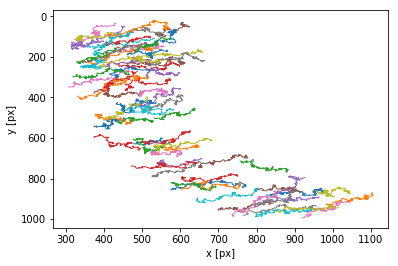

In [ ]:
plt.figure()
tp.plot_traj(traj);

Again, this is just a dataframe, so we can print what we have.  Note the particle entry, which identifies each individual trajectory.

In [ ]:
traj.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
frame,,,,,,,,,,
0,625.056034,570.199353,232.579336,2.504952,0.041531,7.518729,-6340.6166,0.378324,0,1
0,640.970149,644.268657,235.085579,2.397582,0.086365,9.273099,-6321.2878,0.361448,0,8
0,644.126316,555.953684,238.093070,2.452067,0.020601,8.270601,-6309.1125,0.351570,0,10
0,657.988999,488.519252,227.817475,2.533820,0.029005,7.769353,-6223.7246,0.295022,0,15
0,701.525109,653.074236,229.571845,2.418316,0.106599,8.270601,-6176.7284,0.271028,0,19


The particle numbering doesn't necessarily follow any logic.  We can see the unique set of particle numbers as follows.

In [ ]:
print(set(traj['particle']))

{256, 1, 129, 130, 257, 261, 134, 262, 8, 136, 10, 137, 139, 266, 15, 146, 19, 275, 21, 149, 276, 278, 155, 156, 29, 160, 33, 35, 36, 164, 165, 166, 168, 43, 45, 46, 173, 176, 179, 181, 62, 194, 197, 203, 76, 205, 78, 79, 207, 210, 83, 212, 85, 87, 219, 221, 253, 224, 227, 228, 229, 104, 105, 107, 251, 243, 244, 117, 118, 245, 249, 123, 252, 125, 127}


Try to find a single trajectory that has a lot of data and isn't stuck in one position.  You can either do this by going through the particle numbers (shown first) or by selecting out a trajectory using positions.  Some combination of both works also.

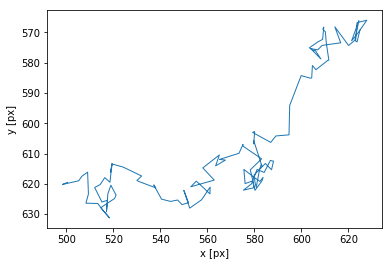

In [ ]:
t2 = traj[(traj['particle']==62)]
plt.figure()
tp.plot_traj(t2);

In [ ]:
# unnecessay because we were able to extract trajectory from above method
t3 = traj[((traj['x']>150) & (traj['x']<250) & (traj['y']>400))]
plt.figure()
tp.plot_traj(t3);

NameError: name 'traj' is not defined

You can also check where your selected particle is in any given frame as follows:

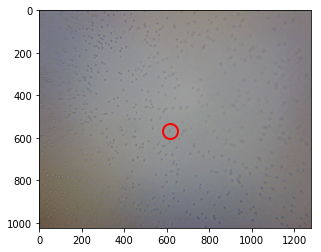

In [ ]:
iframe=10
plt.figure()
tp.annotate(t2[t2['frame'] == iframe], frames[iframe]);


## Extracting position information
Again, we really just have a data frame now selected for one specific particle.  We want to extract the x and y positions from this (and really the difference in x and y positions between frames).

In [ ]:
t2.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
frame,,,,,,,,,,
0,569.268090,624.903915,211.276272,2.472866,0.007857,7.518729,-6493.9649,0.600919,0,62
1,573.117424,623.693182,199.316609,2.434495,0.114170,7.298209,-6513.6647,0.731708,1,62
2,572.850187,623.083645,201.045779,2.429788,0.117441,7.278811,-6551.7468,0.827416,2,62
3,566.785714,623.676692,201.354254,2.397001,0.063581,7.569709,-6545.5941,0.574094,3,62
4,565.985507,627.822464,210.121766,2.414979,0.010127,8.120648,-6501.8857,0.638933,4,62


It is probably easiest to write the x and y positions of your bead to a CSV file which you can then analyze later.  The following command will do that for you.  This can then be read back easily using pandas.  You can also save the entire dataframe if you wish (not just the x and y coordinates).

In [ ]:
t2[['x','y']].to_csv('Particle62_motion.csv')

You should probably continue your analysis in a different notebook, but to help you get started, I will show you how to extract arrays from the dataframe and make a simple histogram of the position differences between video frames.  

There are probably more 'pandas-like' ways to do this, but a simple trick to find the difference between successive elements in a vector is to take the difference between a subset of the vectors with different offsets.  This method insures that the two vectors used in making the diff are the same length.

In [ ]:
# Turn the dataframe into a simple vector using values
xvec = t2['x'].values
# Find the difference in xvec by some number of frames in the video 
offset = 1
xdiff = xvec[offset:]-xvec[:-offset]

Now we have an array of $\Delta x$ differences (separated by $\Delta t$ determined by the offset parameter and the frame rate of the video) which we can use to make a histogram and find the standard deviation.  Note that distance is still measured in pixels.  You will need to calibrate this to get a physically meaningful diffusion.

In [ ]:
plt.hist(xdiff, 20)
plt.xlabel('Delta x (pixels)')
plt.show()
sdx = np.std(xdiff)
print ("SD x: %f pixels" % sdx)

The next steps are up to you.  You will need to do something similar to get the $\Delta y$ distribution, then decide how to combine these to find the diffusion coefficient.  You could also add more data by looking at other beads.  Adjusting the offset will allow you to extract data to demonstrate the linear growth in diffusion with time.